In [1]:
import pyart
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import cartopy.crs as ccrs
from pyproj import Proj, CRS, Transformer
import glob
import xarray as xr
from datetime import datetime, timedelta
import pandas as pd
from scipy.interpolate import griddata
from collections import defaultdict


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Date of the data
year = '2025'
month = '03'
day = '13'

# The path to the data directory
# The data is stored in the following directory structure
# /mnt/gws/data/tone-ico_doppler_scanning_cloud_radar/L0/Y2025/M03/D13/
# The year, month and day are used to construct the path
data='/gws/nopw/j04/tone_ico_gws/data/tone-ico_doppler_scanning_cloud_radar/L0/Y'+year+'/M'+month+'/D'+day+'/*PPI.LV1.NC'
file_list = sorted(glob.glob(data))  

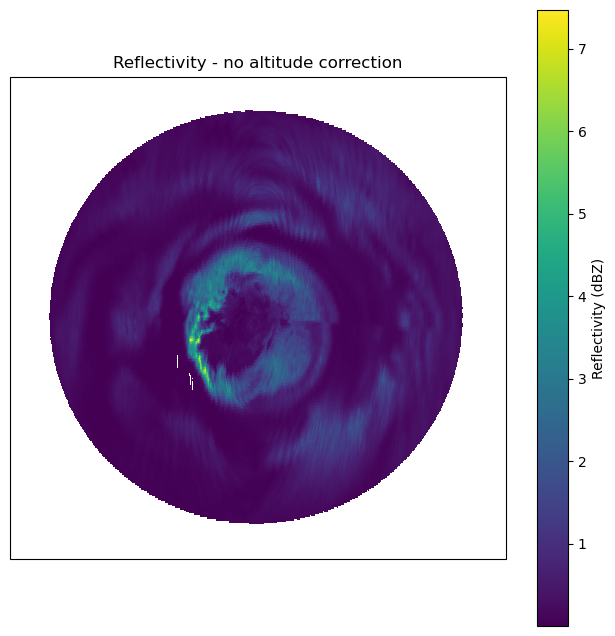

In [42]:
# storing the scans
scansLow = []
scansMid = []
scansHigh = []

# generating the target uniform lat/lon grid
lat_grid = np.arange(-72.15, -71.85, 0.001)
lon_grid = np.arange(2, 3, 0.001)
lon_target, lat_target = np.meshgrid(lon_grid, lat_grid)

# iterating over all the hourly radar scans during the given day, and storing in a common data structure on a common grid
for file in file_list[11:12]:
    ds = xr.open_dataset(file)

    # central lat/lon
    trollLat = ds['GPSLat'].values
    trollLon = ds['GPSLon'].values

    # Stack all CZE variables along the range dimension
    cze_vars = ['C1ZE45', 'C2ZE45', 'C3ZE45', 'C4ZE45']
    data_list = [ds[var].values for var in cze_vars]
    range_list = [ds[var.replace('ZE45', 'Range')].values for var in cze_vars]

    # Concatenate data and ranges
    data_stacked = np.concatenate(data_list, axis=1)  # shape: (n_az, total_range)
    ranges_stacked = np.concatenate(range_list)       # shape: (total_range,)


    # Set all values below -30 to NaN
    data_stacked[data_stacked < -30] = np.nan

    # Generate synthetic azimuths (assuming evenly spaced)
    n_az = ds['Time'].size
    azimuths = np.linspace(0, 2 * np.pi, n_az, endpoint=False)

    # Create 2D grids for polar plot
    azimuths_2d, ranges_2d = np.meshgrid(azimuths, ranges_stacked, indexing='ij')

    # Create Cartesian grids
    X = ranges_2d * np.cos(azimuths_2d)   
    Y = ranges_2d * np.sin(azimuths_2d)   

    # Transform to generate lat/lon grid for individual scan
    crs_centered = CRS.from_proj4(f"+proj=aeqd +lat_0={trollLat} +lon_0={trollLon} +datum=WGS84 +units=m +no_defs")
    crs_geo = CRS.from_epsg(4326)  # WGS84 lat/lon
    transformer = Transformer.from_crs(crs_centered, crs_geo, always_xy=True)
    lon, lat = transformer.transform(X, Y)

    points = np.column_stack((lat.ravel(), lon.ravel()))
    values = data_stacked.ravel()

    # interpolating onto the grid
    dbz = griddata(points, values, (lat_target, lon_target), method='linear', fill_value=np.nan)

    # converting to z
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    # empirical constants from Souverijns et al. (2017)
    aLow = 11
    aMid = 18
    aHigh = 43
    b = 1.1

    # converting from reflectivity to snowfall rate
    precipLow = (z / aHigh) ** (1 / b)
    precipMid = (z / aMid) ** (1 / b)
    precipHigh = (z / aLow) ** (1 / b)

    # taking the mean of the azimuths timestamp to represent the entire scan - IS THIS OK?
    base_time = np.datetime64("2001-01-01T00:00:00")
    timestamp = base_time + np.timedelta64(int(ds['Time'].values.mean()), 's')
    
    # data structure for the scan
    scanMid = {
        "snowfall_rate": precipMid,
        "lat": lat_grid,
        "lon": lon_grid,
        "timestamp": timestamp
    }

    scanLow = {
        "snowfall_rate": precipLow,
        "lat": lat_grid,
        "lon": lon_grid,
        "timestamp": timestamp
    }

    scanHigh = {
        "snowfall_rate": precipHigh,
        "lat": lat_grid,
        "lon": lon_grid,
        "timestamp": timestamp
    }

    scansMid.append(scanMid)
    scansLow.append(scanLow)
    scansHigh.append(scanHigh)

    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())

    ax.set_extent([trollLon-0.5, trollLon+0.5, trollLat-0.15, trollLat+0.15], crs=ccrs.PlateCarree())
    ax.coastlines()

    cf = ax.pcolormesh(lon_grid, lat_grid, dbz, transform=ccrs.PlateCarree(), cmap='viridis')
    plt.colorbar(cf, label='Reflectivity (dBZ)')
    plt.title("Reflectivity - no altitude correction")

    plt.show()

    








In [7]:
# Converting scan dictionaries to xarray

# Extract lat/lon from any scan (they're the same across all scans)
lat = scansMid[0]["lat"]
lon = scansMid[0]["lon"]

# Stack all snowfall_rate arrays into a 3D array
snowStackMid = np.stack([r["snowfall_rate"] for r in scansMid], axis=0)
snowStackLow = np.stack([r["snowfall_rate"] for r in scansLow], axis=0)
snowStackHigh = np.stack([r["snowfall_rate"] for r in scansHigh], axis=0)

# Extract timestamps
timestamps = np.array([r["timestamp"] for r in scansMid])

# Create DataArray
daMid = xr.DataArray(
    snowStackMid,
    coords={"time": timestamps, "lat": lat, "lon": lon},
    dims=("time", "lat", "lon")
)

daLow = xr.DataArray(
    snowStackLow,
    coords={"time": timestamps, "lat": lat, "lon": lon},
    dims=("time", "lat", "lon")
)

daHigh = xr.DataArray(
    snowStackHigh,
    coords={"time": timestamps, "lat": lat, "lon": lon},
    dims=("time", "lat", "lon")
)

# Ensure time is sorted
daMid = daMid.sortby("time")
daLow = daLow.sortby("time")
daHigh = daHigh.sortby("time")

In [23]:
def hourly_accumulation_trapz(da):
    # Ensure time is datetime64 and sorted
    da = da.sortby("time")
    da["time"] = da.indexes["time"].astype("datetime64[ns]")

    # Convert time to numeric hours since start
    time_hours = (da.time - da.time[0]) / np.timedelta64(1, "h")

    # Add as a new coordinate so we can use it inside groupby
    da = da.assign_coords(time_hours=("time", time_hours.data))

    # Group by hour bins (flooring timestamps to the hour)
    hourly_bins = da.time.dt.floor("1H")
    grouped = da.groupby(hourly_bins)

    # Apply np.trapz manually across each group
    def integrate(group):
        t = group.time_hours.values
        y = group.values
        return np.trapz(y, t, axis=0)

    # Stack into DataArray with correct coordinates
    results = []
    coords = []
    for hour, group in grouped:
        if group.time.size >= 2:
            results.append(integrate(group))
            coords.append(hour)
        # Optionally skip singleton bins

    # Convert to DataArray
    accum = xr.DataArray(
        data=np.stack(results),
        coords={"time": np.array(coords), "lat": da.lat, "lon": da.lon},
        dims=("time", "lat", "lon")
    )

    return accum

In [24]:
daMid["time"] = daMid.indexes["time"].astype("datetime64[ns]")
daLow["time"] = daLow.indexes["time"].astype("datetime64[ns]")
daHigh["time"] = daHigh.indexes["time"].astype("datetime64[ns]")

accumMid = hourly_accumulation_trapz(daMid)
accumLow = hourly_accumulation_trapz(daLow)
accumHigh = hourly_accumulation_trapz(daHigh)

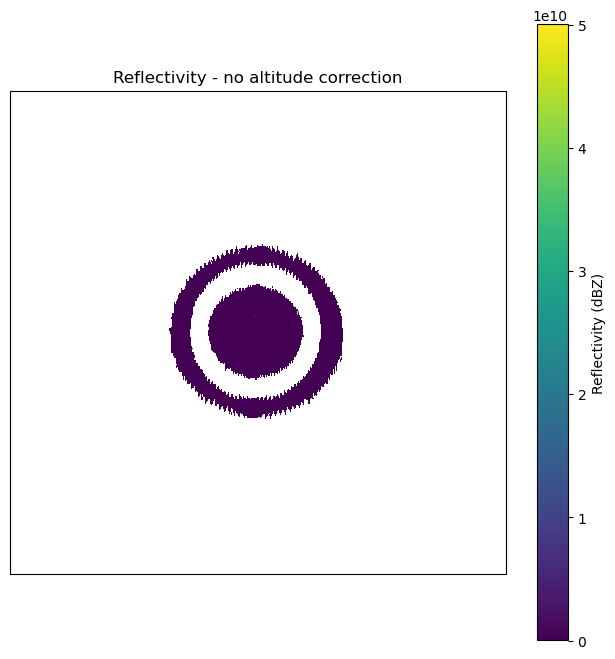

In [36]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

ax.set_extent([trollLon-0.5, trollLon+0.5, trollLat-0.15, trollLat+0.15], crs=ccrs.PlateCarree())
ax.coastlines()

cf = ax.pcolormesh(lon_grid, lat_grid, accumMid[22], transform=ccrs.PlateCarree(), cmap='viridis')
plt.colorbar(cf, label='Reflectivity (dBZ)')
plt.title("Reflectivity - no altitude correction")

plt.show()